In [1]:
#This file contains the code from Step 3: Data Preparation to Step 8: Intepretation.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('dp_to_int').getOrCreate()

In [2]:
#Import essential libraries.
import nbimporter
import iteration4_1_du as du

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt 

from pyspark.sql.functions import col, when, countDistinct, avg, stddev, format_number
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor

Importing Jupyter notebook from iteration4_1_du.ipynb


In [3]:
#Function to get and return the predictors in the dataset.
def get_predictors(dataset):
    columns = dataset.columns
    predictors = [c for c in columns if c not in ["pm","No"]]
    return predictors

In [4]:
#Function to select and keep the useful attributes.
#Those attributes who has more than 80% of the instances with the same value will be deleted.
def feature_selection(dataset):
    predictors = get_predictors(dataset)
    dataset = dataset.toPandas()
    instance_no = dataset.shape[0]
    unimportant_features =[]
    for predictor in predictors:
        predictor_values = dataset[predictor].value_counts()
        for value_amount in predictor_values:
            if value_amount/instance_no > 0.9 :
                unimportant_features.append(predictor)
                dataset = dataset.drop(columns = [predictor])
    print("Unimportant features: ", unimportant_features)
    return dataset

In [5]:
#Function to project the data of numeric predictors by normalizing them and return the projected dataset.
def normalization(dataset):
    predictors = get_predictors(dataset)
    if "cbwd" in predictors:
        predictors.remove("cbwd")
    columns_to_scale = predictors
    assemblers = [VectorAssembler(inputCols=[col], 
                                  outputCol=col + "_vec") for col in columns_to_scale]
    scalers = [MinMaxScaler(inputCol=col + "_vec", 
                            outputCol=col + "_scaled") for col in columns_to_scale]
    pipeline = Pipeline(stages=assemblers + scalers)
    scalerModel = pipeline.fit(dataset)
    scaledData = scalerModel.transform(dataset)
    return scaledData

In [6]:
#Function to analyse the result of the linear regression model by calculating the statistical data of predictions versus actual record.
def analyze_result_lr(model):
    rmse = model.rootMeanSquaredError
    r2 = model.r2
    mae = model.meanAbsoluteError
    print("Root Mean Squared Error:","\t",rmse)
    print("R2 Score:","\t",r2)
    print("Mean Absolute Error:","\t",mae)
    pred_data = model.predictions.select("pm","prediction")
    res = model.residuals
    max_e = res.agg({"residuals":"max"}).collect()[0]
    print("Maximum Error:","\t",max_e["max(residuals)"])
    min_e = res.agg({"residuals":"min"}).collect()[0]
    print("Minimum Error:","\t",min_e["min(residuals)"])
    mean_pm = pred_data.agg({"pm":"mean"}).collect()[0]
    mean_pred = pred_data.agg({"prediction":"mean"}).collect()[0]
    print("Mean Error:","\t", abs(mean_pm["avg(pm)"] - mean_pred["avg(prediction)"]))

In [7]:
#Function to analyse the result of the decision tree regressor model by calculating the statistical data of predictions versus actual record.
def analyze_result_tree(model):
    rmse_evaluator = RegressionEvaluator(labelCol="pm", predictionCol="prediction", 
                                         metricName="rmse")
    r2_evaluator = RegressionEvaluator(labelCol="pm", predictionCol="prediction", 
                                         metricName="r2")
    mae_evaluator = RegressionEvaluator(labelCol="pm", predictionCol="prediction", 
                                         metricName="mae")
    rmse = rmse_evaluator.evaluate(model)
    r2 = r2_evaluator.evaluate(model)
    mae = mae_evaluator.evaluate(model)
    print("Root Mean Squared Error:","\t",rmse)
    print("R2 Score:","\t",r2)
    print("Mean Absolute Error:","\t",mae)
    pred_data = model.select("pm","prediction")
    res = pred_data.withColumn('residuals',pred_data['pm']-pred_data['prediction'])
    max_e = res.agg({"residuals":"max"}).collect()[0]
    print("Maximum Error:","\t",max_e["max(residuals)"])
    min_e = res.agg({"residuals":"min"}).collect()[0]
    print("Minimum Error:","\t",min_e["min(residuals)"])
    mean_pm = pred_data.agg({"pm":"mean"}).collect()[0]
    mean_pred = pred_data.agg({"prediction":"mean"}).collect()[0]
    print("Mean Error:","\t", abs(mean_pm["avg(pm)"] - mean_pred["avg(prediction)"]))

In [8]:
#Function to visualize the residuals of the model.
def visualize_residuals(test_result):
    predictions = test_result.select("prediction").toPandas()
    observations = test_result.select("pm").toPandas()
    sns.residplot(predictions, observations)
    plt.show()
    sns.distplot(observations, kde=False, norm_hist=True, color='blue', label='observation')                                    
    sns.distplot(predictions, kde=False, norm_hist=True, color='red', label='prediction')
    plt.title('Comparison of distributions', fontsize=16)
    plt.legend()
    plt.show()

In [9]:
#Function to compare and visualize the values of actual record and predictions.
def prediction_actual_comparison_visulisation(test_result):
    predictions = test_result.select("prediction").toPandas()
    observations = test_result.select("pm").toPandas()
    plt.scatter(observations,predictions)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

In [10]:
#Function visualizes the feature importance after conducting the model.
def feature_importance(importance_,predictors_):
    importance_value = []
    for value in importance_:
        importance_value.append(abs(value))
    sum_values = sum(importance_value)
    i=0
    while i< len(importance_value):
        importance_value[i] = importance_value[i] / sum_values
        i+=1
    importance_df = pd.Series(importance_value, index= predictors_)
    importance_df.plot(kind='bar')
    plt.show()

In [11]:
#Function to visualize whether the predictors affected the target positively or negatively.
def coefficients(coef_, predictors_):
    colors = []
    related = [1] * len(predictors_)
    for value in coef_:
        if value > 0:
            colors.append('blue')
        else:
            colors.append('orange')
    related_df = pd.Series(related, index = predictors_)
    related_df.plot(kind='bar',color = colors).legend(['Negative','Positive'])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

In [12]:
#Function to visualize how each attribute affects the target respectively.
def effect_graph(coef_, predictors_, intercept_):
    pred = predictors_
    pred.remove('cbwd')
    coeff = coef_[:-1]
    i=0
    for value in coeff:
        x=np.linspace(0,1,100)
        y=value * x + intercept_
        plt.plot(x,y)
        plt.xlabel(pred[i])
        plt.ylabel('pm2.5')
        plt.grid()
        plt.show()
        i+=1

In [13]:
dataset1 = spark.read.csv('./Datasets/PRSA_data_2010.1.1-2014.12.31.csv', inferSchema = True, header = True)

In [14]:
#Construct two new attributes - rain and snow, then show the dataset.
dataset1 = dataset1.withColumn('rain',when(col('Ir')>0, "Yes").otherwise("No"))
dataset1 = dataset1.withColumn('snow',when(col('Is')>0, "Yes").otherwise("No"))
dataset1.show(5)

+---+----+-----+---+----+-----+----+-----+------+----+-----+---+---+----+----+
| No|year|month|day|hour|pm2.5|DEWP| TEMP|  PRES|cbwd|  Iws| Is| Ir|rain|snow|
+---+----+-----+---+----+-----+----+-----+------+----+-----+---+---+----+----+
|  1|2010|    1|  1|   0|   NA| -21|-11.0|1021.0|  NW| 1.79|  0|  0|  No|  No|
|  2|2010|    1|  1|   1|   NA| -21|-12.0|1020.0|  NW| 4.92|  0|  0|  No|  No|
|  3|2010|    1|  1|   2|   NA| -21|-11.0|1019.0|  NW| 6.71|  0|  0|  No|  No|
|  4|2010|    1|  1|   3|   NA| -21|-14.0|1019.0|  NW| 9.84|  0|  0|  No|  No|
|  5|2010|    1|  1|   4|   NA| -20|-12.0|1018.0|  NW|12.97|  0|  0|  No|  No|
+---+----+-----+---+----+-----+----+-----+------+----+-----+---+---+----+----+
only showing top 5 rows



In [15]:
#Append two dataset with same attributes names.
dataset2_a = spark.read.csv('./Datasets/BeijingPM2010_2012.csv', 
                            inferSchema = True, header = True)
dataset2_b = spark.read.csv('./Datasets/BeijingPM2013_2015.csv', 
                            inferSchema = True, header = True)
dataset2 = dataset2_a.union(dataset2_b)
dataset2.count()

52584

In [16]:
#Select the items from the dataset.
#Only the data before 2015 are kept for the further progress.
dataset2 = dataset2.filter('year<2015')
dataset2.count()

43824

In [17]:
#Select the attributes from the dataset.
#Only high-quality and unique data are kept.
#Those duplicated and low-quality attributes are discarded.
dataset2 = dataset2.select("year","month","day","hour","HUMI","precipitation","Iprec")
dataset2.show(5)

+----+-----+---+----+----+-------------+-----+
|year|month|day|hour|HUMI|precipitation|Iprec|
+----+-----+---+----+----+-------------+-----+
|2010|    1|  1|   0|43.0|          0.0|  0.0|
|2010|    1|  1|   1|47.0|          0.0|  0.0|
|2010|    1|  1|   2|43.0|          0.0|  0.0|
|2010|    1|  1|   3|55.0|          0.0|  0.0|
|2010|    1|  1|   4|51.0|          0.0|  0.0|
+----+-----+---+----+----+-------------+-----+
only showing top 5 rows



In [18]:
#Merge two datasets based on the key ('year','month','day','hour').
dataset_final = dataset1.join(dataset2,['year','month','day','hour'])
dataset_final = dataset_final.withColumnRenamed("pm2.5","pm")

#Call the function to set "NA" values to null and change the type of PM2.5 concentration to Integer type for further cleaning.
dataset_final = du.set_NA_to_null(dataset_final)
dataset_final = dataset_final.withColumn("pm",dataset_final["pm"].cast(IntegerType()))
dataset_final.show(5)

+----+-----+---+----+---+----+----+-----+------+----+-----+---+---+----+----+----+-------------+-----+
|year|month|day|hour| No|  pm|DEWP| TEMP|  PRES|cbwd|  Iws| Is| Ir|rain|snow|HUMI|precipitation|Iprec|
+----+-----+---+----+---+----+----+-----+------+----+-----+---+---+----+----+----+-------------+-----+
|2010|    1|  1|   0|  1|null| -21|-11.0|1021.0|  NW| 1.79|  0|  0|  No|  No|43.0|          0.0|  0.0|
|2010|    1|  1|   1|  2|null| -21|-12.0|1020.0|  NW| 4.92|  0|  0|  No|  No|47.0|          0.0|  0.0|
|2010|    1|  1|   2|  3|null| -21|-11.0|1019.0|  NW| 6.71|  0|  0|  No|  No|43.0|          0.0|  0.0|
|2010|    1|  1|   3|  4|null| -21|-14.0|1019.0|  NW| 9.84|  0|  0|  No|  No|55.0|          0.0|  0.0|
|2010|    1|  1|   4|  5|null| -20|-12.0|1018.0|  NW|12.97|  0|  0|  No|  No|51.0|          0.0|  0.0|
+----+-----+---+----+---+----+----+-----+------+----+-----+---+---+----+----+----+-------------+-----+
only showing top 5 rows



In [19]:
#Drop the attributes from the datasets again.
#Only the target and metoerology-related attributes are kept.
dataset_final = dataset_final.drop('year','month','day','hour')
dataset_final.show(5)

+---+----+----+-----+------+----+-----+---+---+----+----+----+-------------+-----+
| No|  pm|DEWP| TEMP|  PRES|cbwd|  Iws| Is| Ir|rain|snow|HUMI|precipitation|Iprec|
+---+----+----+-----+------+----+-----+---+---+----+----+----+-------------+-----+
|  1|null| -21|-11.0|1021.0|  NW| 1.79|  0|  0|  No|  No|43.0|          0.0|  0.0|
|  2|null| -21|-12.0|1020.0|  NW| 4.92|  0|  0|  No|  No|47.0|          0.0|  0.0|
|  3|null| -21|-11.0|1019.0|  NW| 6.71|  0|  0|  No|  No|43.0|          0.0|  0.0|
|  4|null| -21|-14.0|1019.0|  NW| 9.84|  0|  0|  No|  No|55.0|          0.0|  0.0|
|  5|null| -20|-12.0|1018.0|  NW|12.97|  0|  0|  No|  No|51.0|          0.0|  0.0|
+---+----+----+-----+------+----+-----+---+---+----+----+----+-------------+-----+
only showing top 5 rows



In [20]:
#Call the function to check the completion of each column.
du.check_completion(dataset_final)

No 	 100.0 %
pm 	 95.28 %
DEWP 	 100.0 %
TEMP 	 100.0 %
PRES 	 100.0 %
cbwd 	 100.0 %
Iws 	 100.0 %
Is 	 100.0 %
Ir 	 100.0 %
rain 	 100.0 %
snow 	 100.0 %
HUMI 	 100.0 %
precipitation 	 99.94 %
Iprec 	 99.94 %


In [21]:
#Drop the instances with missing values.
dataset_final = dataset_final.na.drop()
du.check_completion(dataset_final)

No 	 100.0 %
pm 	 100.0 %
DEWP 	 100.0 %
TEMP 	 100.0 %
PRES 	 100.0 %
cbwd 	 100.0 %
Iws 	 100.0 %
Is 	 100.0 %
Ir 	 100.0 %
rain 	 100.0 %
snow 	 100.0 %
HUMI 	 100.0 %
precipitation 	 100.0 %
Iprec 	 100.0 %


In [22]:
#Double-check the measurement error.
max_min_df = du.check_max_and_min(dataset_final.select('precipitation','Iprec'))
spark.createDataFrame(max_min_df).show()

+-------------+---+-----+
|   Attributes|Min|  Max|
+-------------+---+-----+
|precipitation|0.0| 69.2|
|        Iprec|0.0|223.0|
+-------------+---+-----+



In [23]:
#Format the string-typed data to numeric type.
indexer = StringIndexer(inputCol = "cbwd", outputCol = "cbwd_trans")
dataset_final = indexer.fit(dataset_final).transform(dataset_final)
indexer = StringIndexer(inputCol = "rain", outputCol = "rain_trans")
dataset_final = indexer.fit(dataset_final).transform(dataset_final)
indexer = StringIndexer(inputCol = "snow", outputCol = "snow_trans")
dataset_final = indexer.fit(dataset_final).transform(dataset_final)
dataset_final = dataset_final.drop('cbwd','rain','snow')
dataset_final = dataset_final.withColumnRenamed('cbwd_trans','cbwd')
dataset_final = dataset_final.withColumnRenamed('rain_trans','rain')
dataset_final = dataset_final.withColumnRenamed('snow_trans','snow')
dataset_final.show()

+---+---+----+----+------+-----+---+---+----+-------------+-----+----+----+----+
| No| pm|DEWP|TEMP|  PRES|  Iws| Is| Ir|HUMI|precipitation|Iprec|cbwd|rain|snow|
+---+---+----+----+------+-----+---+---+----+-------------+-----+----+----+----+
| 25|129| -16|-4.0|1020.0| 1.79|  0|  0|38.0|          0.0|  0.0| 0.0| 0.0| 0.0|
| 26|148| -15|-4.0|1020.0| 2.68|  0|  0|42.0|          0.0|  0.0| 0.0| 0.0| 0.0|
| 27|159| -11|-5.0|1021.0| 3.57|  0|  0|63.5|          0.0|  0.0| 0.0| 0.0| 0.0|
| 28|181|  -7|-5.0|1022.0| 5.36|  1|  0|85.0|          0.0|  0.0| 0.0| 0.0| 1.0|
| 29|138|  -7|-5.0|1022.0| 6.25|  2|  0|85.0|          0.0|  0.0| 0.0| 0.0| 1.0|
| 30|109|  -7|-6.0|1022.0| 7.14|  3|  0|92.0|          0.0|  0.0| 0.0| 0.0| 1.0|
| 31|105|  -7|-6.0|1023.0| 8.93|  4|  0|92.0|          0.0|  0.0| 0.0| 0.0| 1.0|
| 32|124|  -7|-5.0|1024.0|10.72|  0|  0|85.0|          0.0|  0.0| 0.0| 0.0| 0.0|
| 33|120|  -8|-6.0|1024.0|12.51|  0|  0|85.0|          0.0|  0.0| 0.0| 0.0| 0.0|
| 34|132|  -7|-5.0|1025.0| 1

In [24]:
#Write the cleaned data for reiteration later.
dataset_final.write.csv('./Datasets/cleaned_data.csv', mode='overwrite',header = True)

In [25]:
#Call the function to do feature selection.
selected_data = feature_selection(dataset_final)
dataset_final = spark.createDataFrame(selected_data)
dataset_final.show(5)

Unimportant features:  ['Is', 'Ir', 'precipitation', 'Iprec', 'rain', 'snow']
+---+---+----+----+------+----+----+----+
| No| pm|DEWP|TEMP|  PRES| Iws|HUMI|cbwd|
+---+---+----+----+------+----+----+----+
| 25|129| -16|-4.0|1020.0|1.79|38.0| 0.0|
| 26|148| -15|-4.0|1020.0|2.68|42.0| 0.0|
| 27|159| -11|-5.0|1021.0|3.57|63.5| 0.0|
| 28|181|  -7|-5.0|1022.0|5.36|85.0| 0.0|
| 29|138|  -7|-5.0|1022.0|6.25|85.0| 0.0|
+---+---+----+----+------+----+----+----+
only showing top 5 rows



In [26]:
#Call the function to normalize the predictors.
dataset_final = normalization(dataset_final)
dataset_final.columns

['No',
 'pm',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'HUMI',
 'cbwd',
 'DEWP_vec',
 'TEMP_vec',
 'PRES_vec',
 'Iws_vec',
 'HUMI_vec',
 'DEWP_scaled',
 'TEMP_scaled',
 'PRES_scaled',
 'Iws_scaled',
 'HUMI_scaled']

In [27]:
#Drop duplicated columns after normalization.
dataset_final = dataset_final.drop("No","DEWP", "TEMP", "PRES","Iws","HUMI","DEWP_vec", 
                             "TEMP_vec", "PRES_vec","Iws_vec","HUMI_vec")
dataset_final.show(5)

+---+----+--------------------+--------------------+--------------------+--------------------+--------------------+
| pm|cbwd|         DEWP_scaled|         TEMP_scaled|         PRES_scaled|          Iws_scaled|         HUMI_scaled|
+---+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|129| 0.0|[0.35294117647058...|[0.2459016393442623]|[0.5272727272727272]|[0.00237151352116...|[0.3673469387755102]|
|148| 0.0|[0.36764705882352...|[0.2459016393442623]|[0.5272727272727272]|[0.00394662324791...|[0.40816326530612...|
|159| 0.0|[0.4264705882352941]|[0.22950819672131...|[0.5454545454545454]|[0.00552173297465...|[0.6275510204081632]|
|181| 0.0|[0.4852941176470588]|[0.22950819672131...|[0.5636363636363636]|[0.00868965029024...|[0.8469387755102041]|
|138| 0.0|[0.4852941176470588]|[0.22950819672131...|[0.5636363636363636]|[0.01026476001698...|[0.8469387755102041]|
+---+----+--------------------+--------------------+--------------------

In [28]:
#Set predictors as input columns.
assembler = VectorAssembler(
    inputCols=['DEWP_scaled','TEMP_scaled','PRES_scaled','Iws_scaled','HUMI_scaled','cbwd'],
    outputCol="predictors")
dataset_final = assembler.transform(dataset_final)
dataset_final.head(1)

[Row(pm=129, cbwd=0.0, DEWP_scaled=DenseVector([0.3529]), TEMP_scaled=DenseVector([0.2459]), PRES_scaled=DenseVector([0.5273]), Iws_scaled=DenseVector([0.0024]), HUMI_scaled=DenseVector([0.3673]), predictors=DenseVector([0.3529, 0.2459, 0.5273, 0.0024, 0.3673, 0.0]))]

In [29]:
#Select predictors and the target for data mining.
dataset_final = dataset_final.select("predictors","pm")
dataset_final.show()

+--------------------+---+
|          predictors| pm|
+--------------------+---+
|[0.35294117647058...|129|
|[0.36764705882352...|148|
|[0.42647058823529...|159|
|[0.48529411764705...|181|
|[0.48529411764705...|138|
|[0.48529411764705...|109|
|[0.48529411764705...|105|
|[0.48529411764705...|124|
|[0.47058823529411...|120|
|[0.48529411764705...|132|
|[0.48529411764705...|140|
|[0.47058823529411...|152|
|[0.47058823529411...|148|
|[0.47058823529411...|164|
|[0.45588235294117...|158|
|[0.45588235294117...|154|
|[0.45588235294117...|159|
|[0.47058823529411...|164|
|[0.47058823529411...|170|
|[0.47058823529411...|149|
+--------------------+---+
only showing top 20 rows



In [30]:
#Build and choose the parameters for Linear Regression Model.
lr = LinearRegression(featuresCol='predictors', labelCol='pm',
                      fitIntercept=True, standardization=True)

In [31]:
#Build and choose the parameters for Desicion Tree Regressor Model.
tree = DecisionTreeRegressor(featuresCol="predictors", labelCol='pm',
                             maxDepth=5, minInstancesPerNode=1)

In [32]:
#Split the dataset into two parts, 70% for training and 30% for testing.
data_train,data_test = dataset_final.randomSplit([0.7,0.3])
data_train.describe().show()
data_test.describe().show()

+-------+-----------------+
|summary|               pm|
+-------+-----------------+
|  count|            29181|
|   mean|99.09064117062472|
| stddev|92.28512475659365|
|    min|                0|
|    max|              994|
+-------+-----------------+

+-------+-----------------+
|summary|               pm|
+-------+-----------------+
|  count|            12551|
|   mean| 97.4940642179906|
| stddev|91.55469543174897|
|    min|                1|
|    max|              972|
+-------+-----------------+



In [33]:
#Conduct the Linear Regression Model.
lr_model = lr.fit(data_train)
lr_test = lr_model.evaluate(data_test)

In [34]:
#Call the function to analyze the training data of Linear Regression Model.
analyze_result_lr(lr_model.summary)

Root Mean Squared Error: 	 80.23706396254407
R2 Score: 	 0.24403527141654535
Mean Absolute Error: 	 57.81468011483532
Maximum Error: 	 883.7341624867597
Minimum Error: 	 -176.9672632516825
Mean Error: 	 8.01492205937393e-12


In [35]:
#Call the function to analyze the testing data of Linear Regression Model.
analyze_result_lr(lr_test)

Root Mean Squared Error: 	 79.29486985683005
R2 Score: 	 0.2498233527015985
Mean Absolute Error: 	 57.07648693840049
Maximum Error: 	 862.6684561995112
Minimum Error: 	 -167.84121889099265
Mean Error: 	 1.7392546866693408


In [36]:
#Show the residuals of Linear Regression Model.
lr_test.residuals.show()

+-------------------+
|          residuals|
+-------------------+
|  -29.3851756767326|
| -32.53942721297652|
|-34.149824535442605|
|-26.671913213875598|
|-32.731700702071734|
| -28.18426089830571|
| -35.14931985460399|
| -39.68230613715424|
|-24.658709537507605|
| -41.54633678136818|
| -56.60652874565926|
|-24.064838758326786|
|-26.668459809357316|
|-34.188615128466665|
| -32.97782162178159|
| -37.55527049472785|
| -57.72282770427371|
|-55.988563656003464|
| -41.66399011763933|
| -42.95380869842056|
+-------------------+
only showing top 20 rows



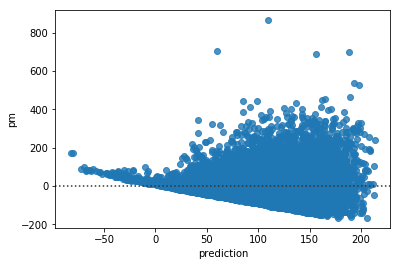

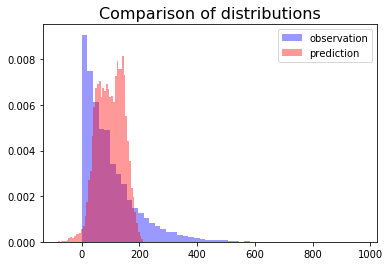

In [37]:
#Call the function to visualize the residuals of Linear Regression Model.
visualize_residuals(lr_test.predictions)

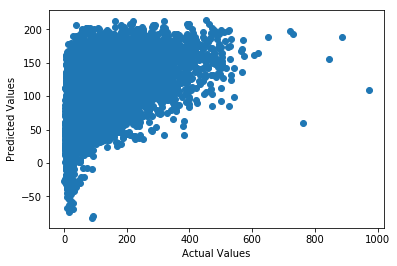

In [38]:
#Call the function to compare and visualize the predictions and actual records of Linear Regression Model.
prediction_actual_comparison_visulisation(lr_test.predictions)

In [39]:
#Show coefficients and intercept of Linear Regression Model.
coef = lr_model.coefficients
intercept = lr_model.intercept
print("Coefficients:","\t",coef)
print("Intercept:","\t",intercept)

Coefficients: 	 [-84.90782152906662,-59.71800704206059,-67.3815633863143,-168.66240238117305,173.2302302463087,-7.893707355109153]
Intercept: 	 136.45462949403935


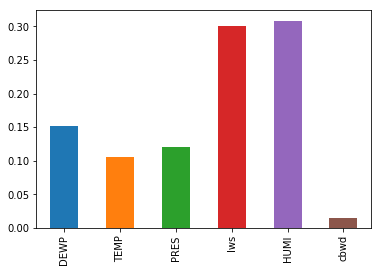

In [40]:
#Call the function to visualize the feature imporatance of Linear Regression Model.
predictors = get_predictors(spark.createDataFrame(selected_data))
feature_importance(coef,predictors)

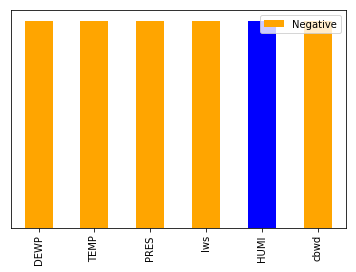

In [41]:
#Call the function to visualize the coefficients.
coefficients(coef, predictors)

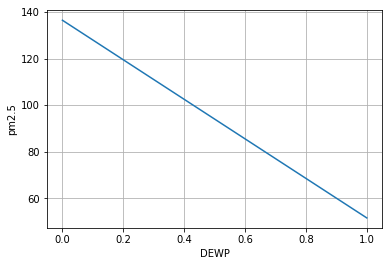

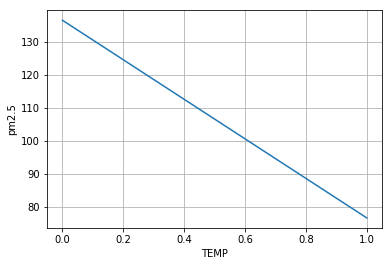

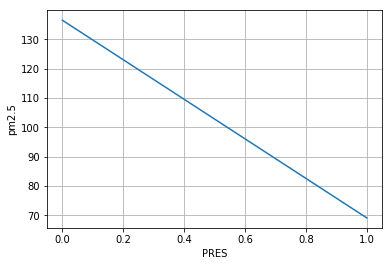

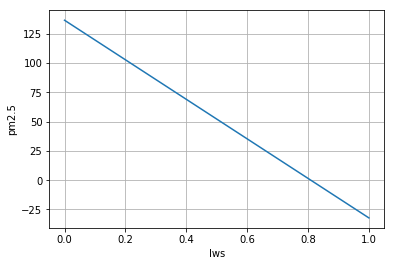

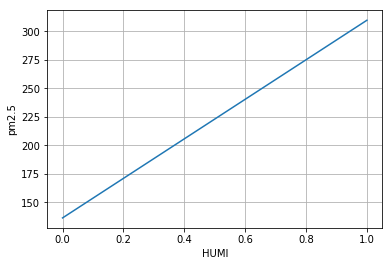

In [42]:
#Call the function to visualize how each attribute affects the target respectively.
effect_graph(coef, predictors, intercept)

In [43]:
#Conduct the Desicion Tree Regressor Model.
tree_model = tree.fit(data_train)
tree_train = tree_model.transform(data_train)
tree_test = tree_model.transform(data_test)

In [44]:
#Call the function to analyze the training data of Desicion Tree Regressor Model.
analyze_result_tree(tree_train)

Root Mean Squared Error: 	 75.86465229365457
R2 Score: 	 0.3241809662265632
Mean Absolute Error: 	 52.98458428045853
Maximum Error: 	 897.5703380588877
Minimum Error: 	 -220.32172131147541
Mean Error: 	 1.1638690011750441e-11


In [45]:
#Call the function to analyze the testing data of Desicion Tree Regressor Model.
analyze_result_tree(tree_test)

Root Mean Squared Error: 	 75.75105620225976
R2 Score: 	 0.3153781676528271
Mean Absolute Error: 	 52.77318566564456
Maximum Error: 	 942.3237774030354
Minimum Error: 	 -214.32172131147541
Mean Error: 	 1.382547664630465


In [46]:
#Show the residuals of Desicion Tree Regressor Model.
predict_data = tree_test.select("pm","prediction")
residuals = predict_data.withColumn('residuals',
            predict_data['pm']-predict_data['prediction']).select("residuals")
residuals.show()

+-------------------+
|          residuals|
+-------------------+
|-11.616839261593878|
|-13.616839261593878|
|-11.616839261593878|
| -7.616839261593878|
|-11.616839261593878|
| -5.616839261593878|
|-21.676222596964585|
|-20.676222596964585|
| -6.616839261593878|
|-16.676222596964585|
|-24.676222596964585|
|-11.616839261593878|
| -6.616839261593878|
|-11.616839261593878|
| -7.616839261593878|
|-20.676222596964585|
|-23.676222596964585|
|-23.676222596964585|
| -7.616839261593878|
|-13.616839261593878|
+-------------------+
only showing top 20 rows



In [47]:
#Show the depth of the Desicion Tree.
tree_model.depth

5

In [48]:
#Show the amount of the nodes of the Desicion Tree.
tree_model.numNodes

63

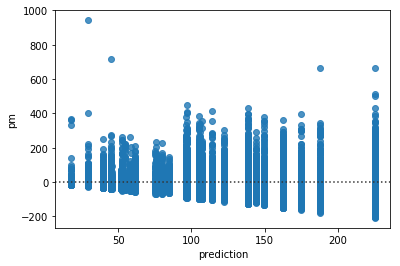

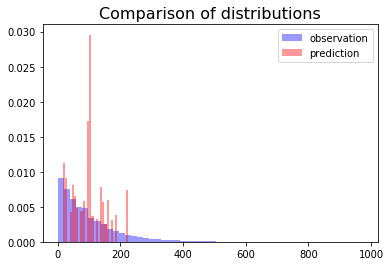

In [49]:
#Call the function to visualize the residuals of Desicion Tree Regressor Model.
visualize_residuals(tree_test)

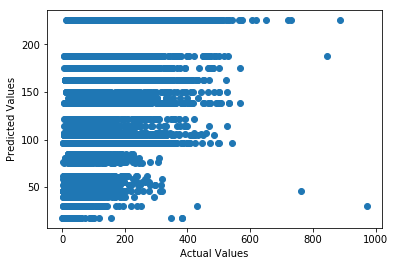

In [50]:
#Call the function to compare and visualize the predictions and actual records of Desicion Tree Regressor Model.
prediction_actual_comparison_visulisation(tree_test)

In [51]:
#Show the feature imporatance of Desicion Tree Regressor Model.
importance = tree_model.featureImportances
importance

SparseVector(6, {0: 0.026, 1: 0.1778, 2: 0.0179, 3: 0.1266, 4: 0.5972, 5: 0.0545})

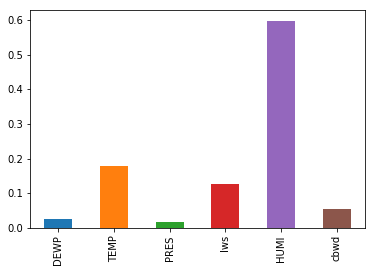

In [52]:
#Call the function to visualize the feature imporatance of Desicion Tree Regressor Model.
predictors = get_predictors(spark.createDataFrame(selected_data))
feature_importance(importance,predictors)

In [53]:
#Show the detailed Desision Tree.
tree_detail = tree_model.toDebugString
for i, feat in enumerate(predictors):
    tree_detail = tree_detail.replace('feature ' + str(i), feat)
print(tree_detail)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4ba78ded3db8c3ffee7b) of depth 5 with 63 nodes
  If (HUMI <= 0.4387755102040816)
   If (cbwd <= 0.0)
    If (HUMI <= 0.2653061224489796)
     If (HUMI <= 0.16326530612244897)
      If (HUMI <= 0.10204081632653061)
       Predict: 45.70952380952381
      Else (HUMI > 0.10204081632653061)
       Predict: 59.002583979328165
     Else (HUMI > 0.16326530612244897)
      If (TEMP <= 0.7213114754098361)
       Predict: 75.90616966580977
      Else (TEMP > 0.7213114754098361)
       Predict: 52.20564516129032
    Else (HUMI > 0.2653061224489796)
     If (TEMP <= 0.6557377049180327)
      If (Iws <= 0.03796191420076455)
       Predict: 114.28137384412153
      Else (Iws > 0.03796191420076455)
       Predict: 84.54131054131054
     Else (TEMP > 0.6557377049180327)
      If (Iws <= 0.004743027042333286)
       Predict: 61.00714285714286
      Else (Iws > 0.004743027042333286)
       Predict: 80.26243781094527
   Else (cbwd > 0.0)
    If (Iws 